## 04. PyTorch Custom Datasets Exercises Template

In [1]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "gpu" if torch.cuda.is_available() \
    else "mps" if torch.backends.mps.is_built() else "cpu"
device

2.1.0.dev20230709


'mps'

### 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

- (1) Add more layers/units to model
    - it may not have enough capability to learn the required patterns/weights/representations of the data
- (2) Tweak the learning rate
    - the laerning rate may be too high to begin with, which is trying to update the wights too much
- (3) Train longer
    - model need more time to learn the representations of data

### 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [2]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

if image_path.is_dir():
    print(image_path, "directory already exists...")
else:
    print(image_path, "does not exist, creating...")
    image_path.mkdir(parents=True, exist_ok=True)


data/pizza_steak_sushi_20_percent does not exist, creating...


In [3]:
# downloading the pizza_steak_sushi_20_percent.zip file
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading...")
    f.write(request.content)

# unzip the file data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping...")
    zip_ref.extractall(image_path)

Downloading...
Unzipping...


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
    """ walks through dir_path returning file counts of its contents """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.


In [6]:
# set up train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [7]:
# visualize random image
import random
from PIL import Image

# get all the image path
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2475366.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1982192.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2353677.jpg')]

(-0.5, 383.5, 511.5, -0.5)

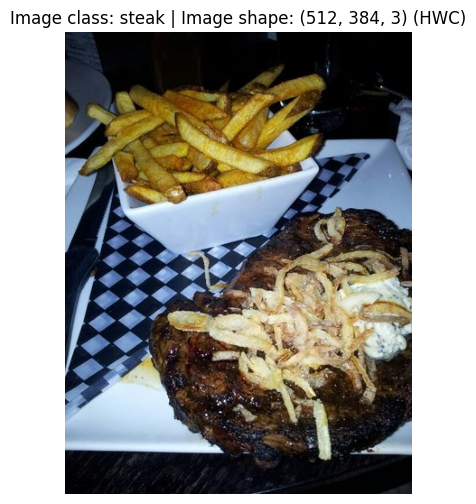

In [8]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# pick a random image
random_image_path = random.choice(image_path_list)
# get the class of the image
image_class = random_image_path.parent.stem
# open image
img = Image.open(random_image_path)

# turn the image into an array
img_array = np.array(img)
# plot the image with matplotlib
plt.figure(figsize=(8,6))
plt.imshow(img_array)
plt.title(f"Image class: {image_class} | Image shape: {img_array.shape} (HWC)")
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [9]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [10]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    # resize image to 64 x 64
    transforms.Resize(size=(64, 64)),
    # flip the image randomly on the horizontal?
    transforms.RandomHorizontalFlip(p = 0.5),
    # tnru into a torch tensor
    transforms.ToTensor()
])

# test the transform
data_transform(img).shape

torch.Size([3, 64, 64])

In [11]:
# Write a function to plot transformed images
def plot_transform_img(image_path:list, transform, n=3, seed=None):
    """
    select random images from 'image_path',load and transform them,
    and plot the original version and the transformed version
    """
    if seed:
        random.seed(seed)
    # random select n images
    random_img_path = random.sample(image_path, k=n)

    for image_path in random_img_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # transform and plot
            # need to change the shape to color channel first
            transform_img = transform(f).permute(1, 2, 0)
            ax[1].imshow(transform_img)
            ax[1].set_title(f"Transformed\nShape: {transform_img.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=14)

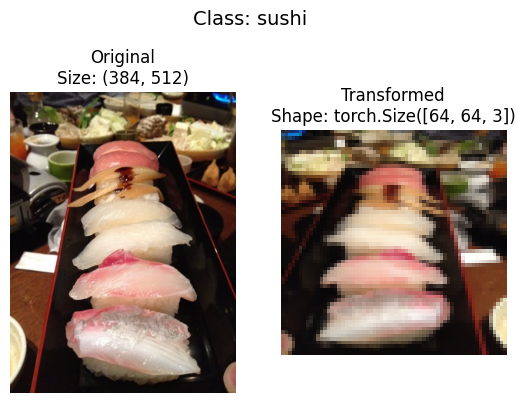

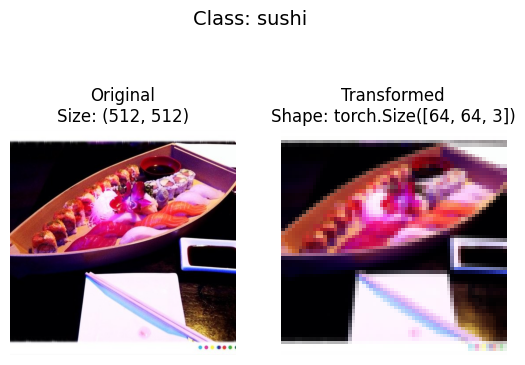

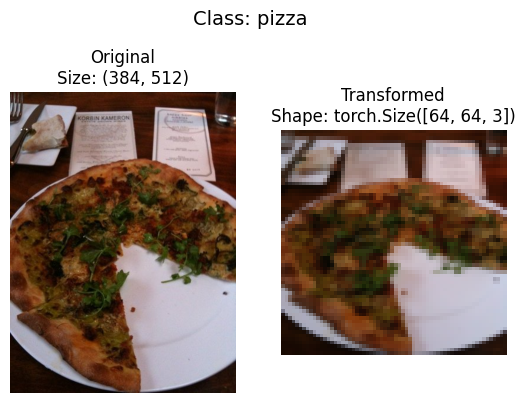

In [12]:
plot_transform_img(image_path_list, data_transform, n=3, seed=None)

#### Load image data using `ImageFolder`

In [13]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # trasform for the data
                                  target_transform=None)    # trasform for the label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data/pizza_steak_sushi_20_percent/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data/pizza_steak_sushi_20_percent/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(450, 150)

In [17]:
# Turn train and test Datasets into DataLoaders
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x14c901cf0>,
 <torch.utils.data.dataloader.DataLoader at 0x14c8bab90>)

In [18]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(15, 5)

### 3. Recreate `model_0` we built in section 7 of notebook 04.

### 4. Create training and testing functions for `model_0`.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader and data batches
  
        # Send data to target device

        # 1. Forward pass
        
        # 2. Calculate and accumulate loss
        

        # 3. Optimizer zero grad 
        

        # 4. Loss backward 
        

        # 5. Optimizer step
        

        # Calculate and accumualte accuracy metric across all batches
    

    # Adjust metrics to get average loss and average accuracy per batch
    

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
    # Put model in eval mode
    model.eval()

    # Setup the test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    
        # Loop through DataLoader batches
        
            # Send data to target device
            

            # 1. Forward pass
            

            # 2. Calculuate and accumulate loss


            # Calculate and accumulate accuracy

      
    # Adjust metrics to get average loss and accuracy per batch

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
    # Create results dictionary
    results = {"train_loss": [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []}

    # Loop through the training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # Train step
        train_loss, train_acc = train_step(model=model, 
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
        # Test step
        test_loss, test_acc = test_step(model=model, 
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        # Print out what's happening
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}"
        )

        # Update the results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the results dictionary
    return results

### 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [ ]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(#TODO, 
                             lr=0.001)

In [ ]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(#TODO, 
                             lr=0.001)

In [ ]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(#TODO, 
                             lr=0.001)

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

### 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [ ]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

### 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [ ]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

In [ ]:
# See how many images we have
walk_through_dir(image_path)

Excellent, we now have double the training and testing images... 

In [ ]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

In [ ]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),                                     
    transforms.ToTensor()
])

# Create datasets


# Create dataloaders

In [ ]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

### 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?